**1. Считать в pandas.DataFrame любой источник данных: CSV**

In [1]:
!pip install catboost

In [35]:
!pip3 install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 790.5 kB/s eta 0:00:00


In [36]:
import category_encoders as ce

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [14]:
# 1. Считываем данные
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
test_marks = r"/content/gender_submission.csv"

In [15]:
df_test_marks = pd.read_csv(test_marks)
df_test["Survived"] = df_test_marks["Survived"]

**2. Датасет и подготовка данных:**

Привести описание датасета.

Обучающий набор следует использовать для построения моделей машинного обучения. Для обучающего набора мы предоставляем результат (также известный как «основная истина») для каждого пассажира. Ваша модель будет основана на таких «особенностях», как пол и класс пассажиров. Вы также можете использовать разработку функций для создания новых функций.

Набор тестов следует использовать, чтобы увидеть, насколько хорошо ваша модель работает на невидимых данных. Для тестового набора мы не предоставляем основную информацию о каждом пассажире. Ваша задача — предсказать эти результаты. Для каждого пассажира в тестовом наборе используйте обученную вами модель, чтобы предсказать, пережили ли они затопление Титаника.

survival	Survival	0 = No, 1 = Yes

pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd

sex	Sex

Age	Age in years

sibsp	# of siblings / spouses aboard the Titanic

parch	# of parents / children aboard the Titanic

ticket	Ticket number

fare	Passenger fare

cabin	Cabin number

embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [16]:
print(df_train.info())
print(df_test.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId      Pclass         Age       SibSp       Parch  \
count   418.000000  418.000000  332.000000  418.000000  418.000000   
mean   1100.500000    2.265550   30.272590    0.447368    0.392344   
std     120.810458    0.84183

In [22]:
df_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [21]:
# Проверка на наличие пропущенных значений
print(df_train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [20]:
print(df_test.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Survived         0
dtype: int64


Осуществить предобработку данных (избавиться от null, убрать некоторые признаки и т.п.) - "подчистить данные".

Удалим лишние признаки 'PassengerId', 'Name', 'Ticket', 'Cabin', они не нужны

In [23]:
# Предобработка данных
drop_columns = ['PassengerId', 'Name', 'Ticket', 'Cabin']
df_train = df_train.drop(drop_columns, axis=1)
df_test = df_test.drop(drop_columns, axis=1)

In [24]:
# Заполняем пропущенные значения в числовых признаках средними значениями
df_train['Age'].fillna(df_train['Age'].mean(), inplace=True)
df_test['Age'].fillna(df_test['Age'].mean(), inplace=True)

Удалим нулевые строки

In [27]:
# Удаляем строки с пропущенными значениями в остальных столбцах
df_train = df_train.dropna()
df_test = df_test.dropna()

In [28]:
print(df_test.isnull().sum())

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Survived    0
dtype: int64


Нормализация числовых данных

In [12]:
# 4. Нормализация числовых данных
numeric_features = ['Age', 'Fare']
scaler = StandardScaler()
train_data[numeric_features] = scaler.fit_transform(train_data[numeric_features])
test_data[numeric_features] = scaler.transform(test_data[numeric_features])

Разделение на признаки и целевую переменную

In [32]:
df = pd.concat([df_train, df_test], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306 entries, 0 to 1305
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  1306 non-null   int64  
 1   Pclass    1306 non-null   int64  
 2   Sex       1306 non-null   object 
 3   Age       1306 non-null   float64
 4   SibSp     1306 non-null   int64  
 5   Parch     1306 non-null   int64  
 6   Fare      1306 non-null   float64
 7   Embarked  1306 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 81.8+ KB


Разделение на тренировочную и тестовую выборки в соотношении 0.3

In [33]:
df_train, df_test, train_mark, test_mark = split(df, marks = 'Survived')

In [39]:
df_train_en, df_test_en, train_mark, test_mark = split(df, marks = 'Survived', sc = 2)

In [34]:
df_train

,Pclass,Age,SibSp,Parch,Fare
672,2,31.0,0,0,13.0000
554,1,62.0,0,0,26.5500
727,2,25.0,1,0,26.0000
934,3,25.0,0,0,7.9250
889,3,34.5,0,0,7.8292
...,...,...,...,...,...
1095,2,24.0,0,0,10.5000
1130,1,45.0,1,1,134.5000
1294,2,23.0,1,0,10.5000
860,1,48.0,0,0,25.9292


Закодированные категориальные признаки 'Sex' и 'Embarked. Применим Target Encoding

In [37]:
categorical_cols = ['Sex', 'Embarked']
target_encoder = ce.TargetEncoder(cols=categorical_cols)

In [40]:
df_train_encoded = target_encoder.fit_transform(df_train_en, train_mark)
df_test_encoded = target_encoder.transform(df_test_en)

**3. Для каждого классификатора:**

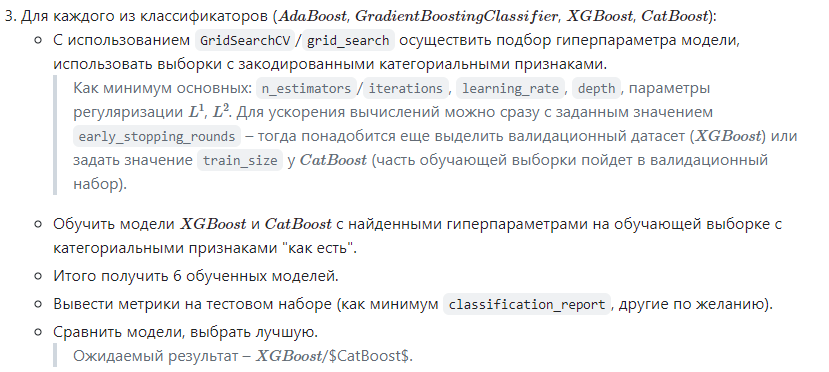

**AdaBoost**

In [44]:
param_grid_adaboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

**GradientBoostingClassifier**

In [45]:
param_grid_gradientboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

**XGBoost**

In [46]:
param_grid_xgboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 7],
    'reg_alpha': [0, 0.1, 1.0],
    'reg_lambda': [0, 0.1, 1.0]
}

**CatBoost**

In [47]:
param_grid_catboost = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [1, 3, 5],
}

Определим модели

In [50]:
def grid_search_classification(model, param_grid, model_name, X_train=df_train, y_train=train_mark, X_test=df_test):
    grid_search = GridSearchCV(model, param_grid, cv=3)
    grid_search.fit(X_train, y_train)
    best_estimator = grid_search.best_estimator_
    y_pred = best_estimator.predict(X_test)
    return best_estimator, y_pred

In [49]:
AdaBoost = AdaBoostClassifier()
gradientboost = GradientBoostingClassifier()
xgboost = XGBClassifier()
catboost = CatBoostClassifier()

In [51]:
best_model_AdaBoost, y_pred_AdaBoost = grid_search_classification (AdaBoost, param_grid_adaboost, name_m = "AdaBoost", df_train = df_train_encoded, df_test = df_test_encoded)

In [52]:
best_model_gradientboost, y_pred_gradientboost = grid_search_classification (gradientboost, param_grid_gradientboost, name_m = "gradientboost", df_train = df_train_encoded, df_test = df_test_encoded)

In [53]:
best_model_xgboost, y_pred_xgboost = grid_search_classification (xgboost, param_grid_xgboost, name_m = "xgboost", df_train = df_train_encoded, df_test = df_test_encoded)

In [54]:
best_model_catboost, y_pred_catboost = grid_search_classification (catboost, param_grid_catboost, name_m = "catboost", df_train = df_train_encoded, df_test = df_test_encoded)

Выходные данные были обрезаны до нескольких последних строк (5000).
100:	learn: 0.3635003	total: 276ms	remaining: 271ms
101:	learn: 0.3616442	total: 279ms	remaining: 268ms
102:	learn: 0.3601614	total: 282ms	remaining: 266ms
103:	learn: 0.3590827	total: 285ms	remaining: 263ms
104:	learn: 0.3574013	total: 288ms	remaining: 261ms
105:	learn: 0.3560593	total: 292ms	remaining: 259ms
106:	learn: 0.3545497	total: 296ms	remaining: 257ms
107:	learn: 0.3531463	total: 299ms	remaining: 255ms
108:	learn: 0.3518846	total: 303ms	remaining: 253ms
109:	learn: 0.3505019	total: 307ms	remaining: 251ms
110:	learn: 0.3501566	total: 310ms	remaining: 249ms
111:	learn: 0.3489485	total: 312ms	remaining: 245ms
112:	learn: 0.3482360	total: 315ms	remaining: 242ms
113:	learn: 0.3479154	total: 317ms	remaining: 239ms
114:	learn: 0.3466499	total: 320ms	remaining: 236ms
115:	learn: 0.3455042	total: 324ms	remaining: 235ms
116:	learn: 0.3444701	total: 333ms	remaining: 236ms
117:	learn: 0.3430957	total: 336ms	remaining: 23

Обучить модели **XGBoost** и **CatBoost** с найденными гиперпараметрами на обучающей выборке с категориальными признаками "как есть".


In [55]:
best_model_xgboost_nen, y_pred_xgboost_nen = grid_classif (xgboost, param_grid_xgboost, name_m = "xgboost", df_train = df_train, df_test = df_test)

In [56]:
best_model_catboost_nen, y_pred_catboost_nen = grid_classif (catboost, param_grid_catboost, name_m = "catboost", df_train = df_train, df_test = df_test)

Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 0.6660517	total: 7.3ms	remaining: 1.45s
1:	learn: 0.6431962	total: 9.32ms	remaining: 922ms
2:	learn: 0.6266673	total: 13.3ms	remaining: 874ms
3:	learn: 0.6150723	total: 18.2ms	remaining: 893ms
4:	learn: 0.6018582	total: 22.7ms	remaining: 887ms
5:	learn: 0.5949152	total: 26.9ms	remaining: 871ms
6:	learn: 0.5875897	total: 30ms	remaining: 827ms
7:	learn: 0.5746004	total: 33.9ms	remaining: 815ms
8:	learn: 0.5640863	total: 39.5ms	remaining: 838ms
9:	learn: 0.5534648	total: 44.6ms	remaining: 847ms
10:	learn: 0.5441143	total: 50.2ms	remaining: 862ms
11:	learn: 0.5379819	total: 57.7ms	remaining: 905ms
12:	learn: 0.5333119	total: 59.9ms	remaining: 861ms
13:	learn: 0.5268565	total: 64.3ms	remaining: 854ms
14:	learn: 0.5209111	total: 67.2ms	remaining: 828ms
15:	learn: 0.5134758	total: 70.5ms	remaining: 811ms
16:	learn: 0.5085707	total: 73.9ms	remaining: 796ms
17:	learn: 0.5055307	total: 77.4ms	remaining: 782ms
18:	learn

Итого получить 6 обученных моделей.

Вывести метрики на тестовом наборе (как минимум classification_report, другие по желанию).

In [57]:
from sklearn.metrics import classification_report

In [64]:
report_AdaBoost = classification_report(test_mark, y_pred_AdaBoost)
report_gradientboost = classification_report(test_mark, y_pred_gradientboost)
report_xgboost = classification_report(test_mark, y_pred_xgboost)
report_catboost = classification_report(test_mark, y_pred_catboost)
report_xgboost_nen = classification_report(test_mark, y_pred_xgboost_nen)
report_catboost_nen = classification_report(test_mark, y_pred_catboost_nen)

full_report = f"""
AdaBoost:
{report_AdaBoost}

GradientBoost:
{report_gradientboost}

XGBoost:
{report_xgboost}

CatBoost:
{report_catboost}

XGBoost_nen:
{report_xgboost_nen}

CatBoost_nen:
{report_catboost_nen}
"""

print(full_report)


AdaBoost:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       240
           1       0.85      0.78      0.81       152

    accuracy                           0.86       392
   macro avg       0.86      0.84      0.85       392
weighted avg       0.86      0.86      0.86       392


GradientBoost:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       240
           1       0.88      0.78      0.83       152

    accuracy                           0.87       392
   macro avg       0.87      0.86      0.86       392
weighted avg       0.87      0.87      0.87       392


XGBoost:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       240
           1       0.88      0.78      0.83       152

    accuracy                           0.87       392
   macro avg       0.87      0.86      0.86       392
weighted avg       0.87      0.87    

1. **CatBoost** показывает наилучшую точность (accuracy) среди всех моделей с результатом 0.88.
2. AdaBoost, GradientBoost и XGBoost также имеют высокие показатели accuracy, достигая 0.87.
3. **CatBoost** также имеет лучший средний показатель F1-score с результатом 0.87, остальные модели показывают примерно одинаковые результаты по данному показателю.
4. Когда рассматривается precision и recall для класса 1, **CatBoost** и **XGBoost** показывают лучшие результаты.

Так что, лучшей моделью я бы назвал **CatBoost**

**4. Важность признаков:**

In [65]:
!pip install --upgrade shap

In [142]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image
import pydotplus

С использованием shap.TreeExplainer получить SHAP-значения для лучшей модели.

In [116]:
explain = shap.TreeExplainer(best_model_catboost, data=df_train_encoded)

In [75]:
# Создаем объект CatBoostExplainer для лучшей модели CatBoost
explainer_catboost = shap.Explainer(best_model_catboost)

# Получаем SHAP значения
shap_values_catboost = explainer_catboost.shap_values(df_test_encoded)

In [79]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0],df_train_encoded.iloc[0])
shap.force_plot(explainer.expected_value, shap_values[:100], df_train_encoded.iloc[:100])  # Срез

Построить график shap.plots.force для одного объекта выборки и для среза произвольного размера.

In [82]:
# Create the explainer object
explainer_catboost = shap.Explainer(best_model_catboost)

# Call initjs() to load the necessary Javascript
shap.initjs()

# Visualization code continues as before
sample_idx = 0
shap.force_plot(explainer_catboost.expected_value, shap_values_catboost[sample_idx], df_test_encoded.iloc[sample_idx])

Построить график shap.plots.bar для одного объекта выборки.

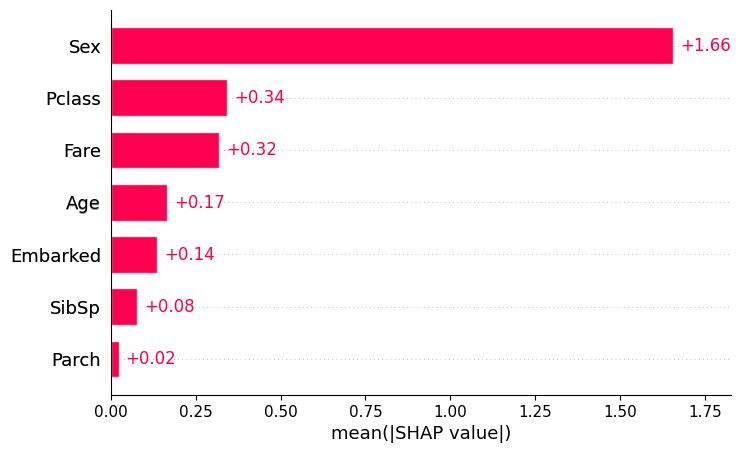

In [84]:
expl = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=df_train_encoded, feature_names=df_train_encoded.columns)
shap.plots.bar(expl)  # График для первого объекта

Построить график shap.plots.waterfall для одного объекта выборки.

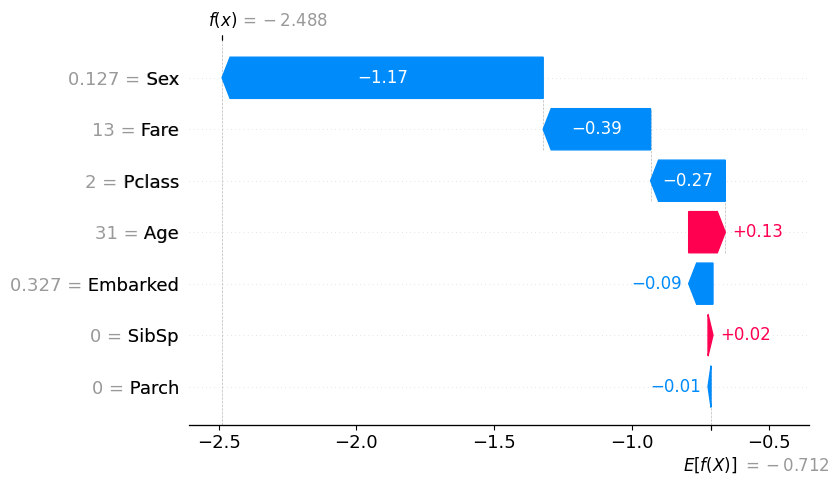

In [86]:
expl1 = shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=df_train_encoded.iloc[0])

shap.plots.waterfall(expl1)  # График для первого объекта

Построить 2 графика shap.plots.scatter для какого-нибудь признака. На одном раскрасить относительно себя, на втором – относительно другого признака.

In [90]:
feature_names=df_train_encoded.columns

In [107]:
# Создание объекта Explanation
ex = shap.Explanation(shap_values, feature_names=df_test_encoded.columns)

Построить график shap.plots.beeswarm для всех признаков.

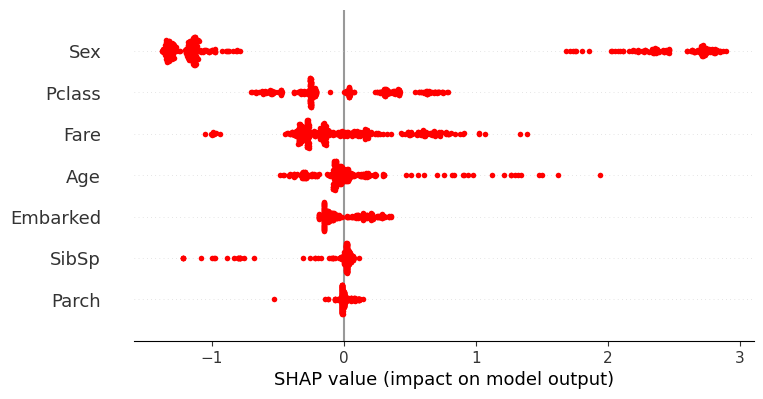

In [108]:
shap.plots.beeswarm(ex, color = 'red')

Построить график shap.plots.bar для всех признаков.

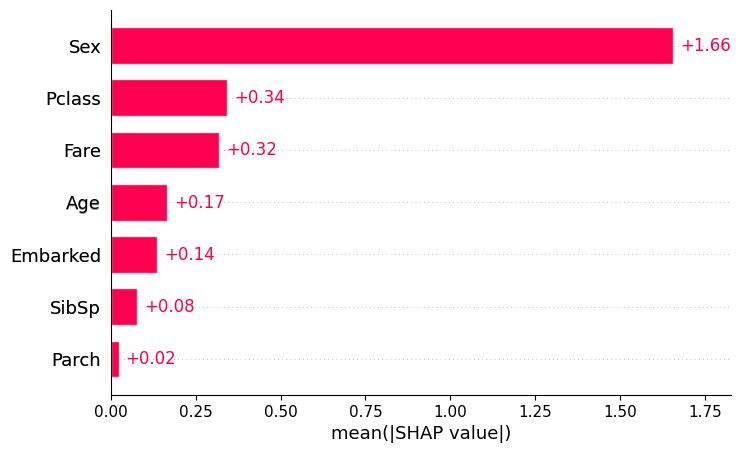

In [110]:
shap.plots.bar(ex)

На основании двух последних графиков и/или используя feature_importance отфильровать признаки (отразить сформулированные выводы в тексте), переобучить лучшую модель.

ПО последним графикам видно, что SibSp и Parch имеют меньше всего влияния. Можем эти признаки сбросить. Так же можно попоробовать удалить Age и Embarked и попробовать на 3 признаках

In [129]:
new_df_train = df_train_encoded.drop(['Parch', 'Age', 'SibSp', 'Embarked'], axis=1)

In [130]:
new_df_train.shape

(914, 3)

In [131]:
new_df_train.head()

,Pclass,Sex,Fare
672,2,0.127334,13.0000
554,1,0.127334,26.5500
727,2,0.127334,26.0000
934,3,0.127334,7.9250
889,3,0.127334,7.8292


In [132]:
new_df_test = df_test_encoded.drop(['Parch', 'Age', 'SibSp', 'Embarked'], axis=1)

In [133]:
new_df_test.shape

(392, 3)

In [134]:
new_df_test.head()

,Pclass,Sex,Fare
1173,3,0.127334,7.2500
514,1,0.127334,34.0208
844,3,0.127334,69.5500
855,1,0.127334,26.5500
1301,3,0.127334,8.0500


In [140]:
best_model_catboost, y_pred_catboost_new = grid_search_classification (catboost, param_grid_catboost, name_m = "catboost", df_train = new_df_train, df_test = new_df_test)

Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 0.6391411	total: 658us	remaining: 131ms
1:	learn: 0.5713027	total: 1.84ms	remaining: 183ms
2:	learn: 0.5282702	total: 2.52ms	remaining: 166ms
3:	learn: 0.4934799	total: 3.26ms	remaining: 160ms
4:	learn: 0.4616024	total: 4.22ms	remaining: 165ms
5:	learn: 0.4482467	total: 4.78ms	remaining: 155ms
6:	learn: 0.4326212	total: 5.46ms	remaining: 151ms
7:	learn: 0.4210445	total: 6.13ms	remaining: 147ms
8:	learn: 0.4102663	total: 6.81ms	remaining: 144ms
9:	learn: 0.4002687	total: 7.48ms	remaining: 142ms
10:	learn: 0.3966128	total: 8.02ms	remaining: 138ms
11:	learn: 0.3915935	total: 8.86ms	remaining: 139ms
12:	learn: 0.3843336	total: 9.9ms	remaining: 142ms
13:	learn: 0.3792293	total: 11.2ms	remaining: 149ms
14:	learn: 0.3769504	total: 12ms	remaining: 148ms
15:	learn: 0.3754043	total: 12.7ms	remaining: 146ms
16:	learn: 0.3737038	total: 13.4ms	remaining: 144ms
17:	learn: 0.3720270	total: 14.1ms	remaining: 143ms
18:	learn:

In [141]:
print(classification_report(test_mark, y_pred_catboost_new))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       240
           1       0.87      0.76      0.81       152

    accuracy                           0.86       392
   macro avg       0.86      0.84      0.85       392
weighted avg       0.86      0.86      0.86       392



А вот как было до:

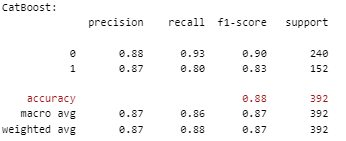

Результат почти не изменился, даже немного ухудшился.

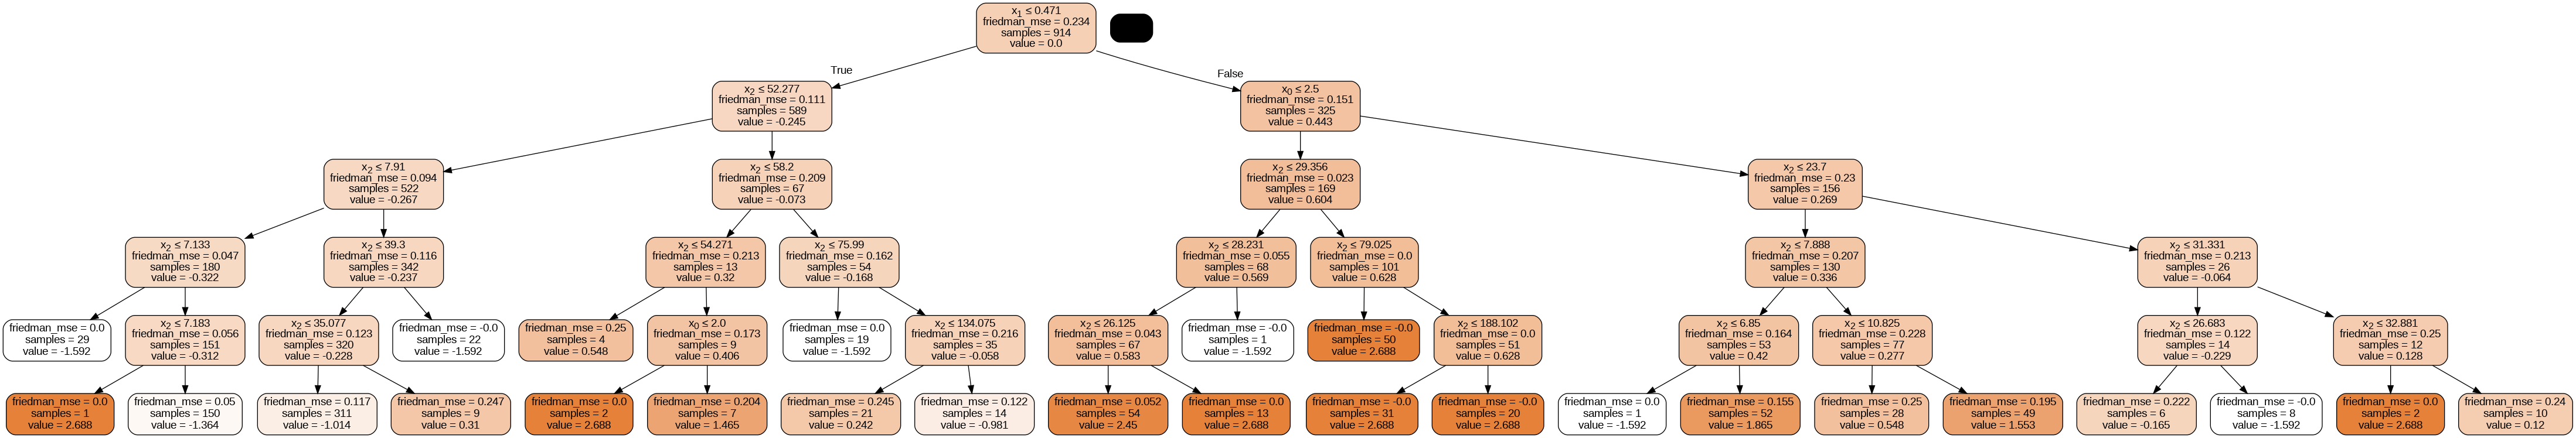

In [145]:
# Выберем одно из деревьев из композиции модели
tree_to_visualize = best_model_gradientboost.estimators_[0, 0]

# Создаем объект, который содержит описание дерева в формате DOT
dot_data = StringIO()
export_graphviz(tree_to_visualize, out_file=dot_data, filled=True, rounded=True,
                special_characters=True)

# Создаем граф из описания дерева
graph_tree = pydotplus.graph_from_dot_data(dot_data.getvalue())

# Отображаем граф в виде изображения
Image(graph_tree.create_png())

**5. Регрессия:**

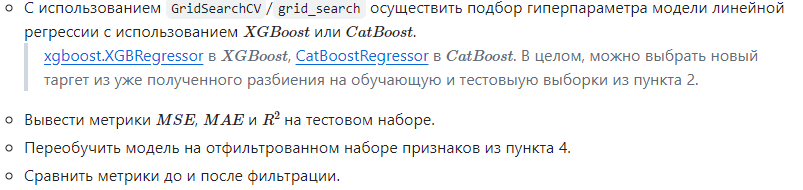

In [155]:
from catboost import CatBoostRegressor

In [161]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [157]:
param_grid = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [1, 3, 5],
}

In [159]:
catboost_model = CatBoostRegressor()

In [160]:
best_model_catboost, y_pred_catboost = grid_search_classification (catboost_model, param_grid, name_m = "catboost_reg", df_train = df_train_encoded, df_test = df_test_encoded)

Выходные данные были обрезаны до нескольких последних строк (5000).
100:	learn: 0.3500506	total: 249ms	remaining: 244ms
101:	learn: 0.3494573	total: 251ms	remaining: 241ms
102:	learn: 0.3488954	total: 252ms	remaining: 237ms
103:	learn: 0.3482047	total: 255ms	remaining: 235ms
104:	learn: 0.3477890	total: 256ms	remaining: 232ms
105:	learn: 0.3473404	total: 257ms	remaining: 228ms
106:	learn: 0.3466311	total: 258ms	remaining: 225ms
107:	learn: 0.3461102	total: 261ms	remaining: 222ms
108:	learn: 0.3454220	total: 263ms	remaining: 220ms
109:	learn: 0.3448516	total: 265ms	remaining: 217ms
110:	learn: 0.3442393	total: 268ms	remaining: 215ms
111:	learn: 0.3438169	total: 269ms	remaining: 212ms
112:	learn: 0.3433513	total: 270ms	remaining: 208ms
113:	learn: 0.3427213	total: 273ms	remaining: 206ms
114:	learn: 0.3422872	total: 275ms	remaining: 203ms
115:	learn: 0.3417686	total: 276ms	remaining: 200ms
116:	learn: 0.3410919	total: 279ms	remaining: 198ms
117:	learn: 0.3407478	total: 281ms	remaining: 19

Выведем метрики и посмотрим что получилось

In [162]:
predictions = best_model_catboost.predict(df_test_encoded)
mse = mean_squared_error(test_mark, predictions)
mae = mean_absolute_error(test_mark, predictions)
r2 = r2_score(test_mark, predictions)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'(R^2): {r2}')

MSE: 0.1056568309162349
MAE: 0.20929220418319808
(R^2): 0.5549437701230175


Переобучим на отфильтрованном наборе признаков

In [164]:
best_model_catboost, y_pred_catboost = grid_search_classification (catboost_model, param_grid, name_m = "catboost_reg", df_train = new_df_train, df_test = new_df_test)

Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 0.4628101	total: 249us	remaining: 49.7ms
1:	learn: 0.4450026	total: 553us	remaining: 54.8ms
2:	learn: 0.4275564	total: 890us	remaining: 58.5ms
3:	learn: 0.4122885	total: 1.53ms	remaining: 75ms
4:	learn: 0.3998156	total: 2.23ms	remaining: 86.9ms
5:	learn: 0.3891580	total: 2.92ms	remaining: 94.5ms
6:	learn: 0.3814890	total: 3.52ms	remaining: 97ms
7:	learn: 0.3744599	total: 4.01ms	remaining: 96.4ms
8:	learn: 0.3676207	total: 5.13ms	remaining: 109ms
9:	learn: 0.3622505	total: 6.22ms	remaining: 118ms
10:	learn: 0.3567699	total: 7.57ms	remaining: 130ms
11:	learn: 0.3529721	total: 8.22ms	remaining: 129ms
12:	learn: 0.3498366	total: 8.79ms	remaining: 126ms
13:	learn: 0.3479319	total: 9.28ms	remaining: 123ms
14:	learn: 0.3456811	total: 9.98ms	remaining: 123ms
15:	learn: 0.3441659	total: 10.6ms	remaining: 121ms
16:	learn: 0.3425710	total: 11.1ms	remaining: 120ms
17:	learn: 0.3416219	total: 11.7ms	remaining: 118ms
18:	l

In [165]:
predictions = best_model_catboost.predict(new_df_test)
mse = mean_squared_error(test_mark, predictions)
mae = mean_absolute_error(test_mark, predictions)
r2 = r2_score(test_mark, predictions)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'(R^2): {r2}')

MSE: 0.10466814090344134
MAE: 0.20267987732725942
(R^2): 0.5591084099839252


И как было до фильтрации

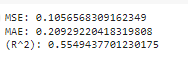

По метрикам можно сказать, что модель выглядит по лучше на отфильтрованном наборе признаков